# Ashley Piar counting code test

In [3]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

/n/home00/lee.5922/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [225]:
#&sr,&cr,&sd,&cd,&zd,&w

In [226]:
def adding_dc_column(data, h = 0.6777, Om0 = 0.3, zlabel = 'Z'):
    
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=h*100, Om0=Om0)
    print 'Calculate comoving distance with cosmology \nH0={}, Om0={}'.format(h, Om0)
    sys.stdout.flush()
    r = cosmo.comoving_distance(data[zlabel]).value *h
    #r_rand = cosmo.comoving_distance(rand[zlabel]).value *h
    from numpy.lib import recfunctions as rf
    #print 'Adding Comoving distance column'
    sys.stdout.flush()
    data = rf.append_fields( data, 'DC', data = r )
    #rand = rf.append_fields( rand, 'DC', data = r_rand )
    return data    

def constructing_input_file(cat, isrand = False, suffix = ''):
    
    cat = adding_dc_column(cat)    
    chunk = cat.size /1000000
    
    for i in range(chunk+1):
        cat_sub = cat[i*1000000:1000000*(i+1)]
        fname = suffix+'_'+str(i)+'pcadw.dat'
        
        ra = cat_sub['RA']
        dec = cat_sub['DEC']
        dc = cat_sub['DC']
        if isrand : weight = cat_sub['WEIGHT_FKP']
        else : weight = cat_sub['WEIGHT_FKP']*cat_sub['WEIGHT_SYSTOT']\
            *( cat_sub['WEIGHT_CP'] + cat_sub['WEIGHT_NOZ'] - 1.)
           
        DAT = np.column_stack((np.sin(ra), np.cos(ra), np.sin(dec), np.cos(dec), dc, weight))
        #os.mkdir('data_txt/pair_counting/')
        np.savetxt('data_txt/pair_counting/'+fname, DAT)
        print 'file saved to ','data_txt/pair_counting/'+fname

def _constructing_input_file(cat, rand, root = 'data_txt/pair_counting/', suffix = ''):
    
    cat = adding_dc_column(cat)
    rand = adding_dc_column(rand)
    print cat.size, rand.size
    
    #chunk = cat.size /1000000
    root = 'data_txt/pair_counting/'
    _root = root + suffix+'/'
    if not os.path.exists(_root) : os.makedirs(_root)
    
    for i in range(100):
        #cat_sub = cat #[i*1000000:1000000*(i+1)]
        if os.path.exists(_root+'ddjk'+str(i)+'pcadw.dat') : pass
        else : 
            fname = _root+'ddjk'+str(i)+'pcadw.dat'
            fname_rr = _root+'rrjk'+str(i)+'pcadw.dat'
            break
        
    ra = cat['RA']
    dec = cat['DEC']
    dc = cat['DC']
    weight = cat['WEIGHT_FKP']*cat['WEIGHT_SYSTOT']\
        *( cat['WEIGHT_CP'] + cat['WEIGHT_NOZ'] - 1.)

    DAT = np.column_stack((np.sin(ra), np.cos(ra), np.sin(dec), np.cos(dec), dc, weight))
    np.savetxt(fname, DAT)
    
    
    ra = rand['RA']
    dec = rand['DEC']
    dc = rand['DC']
    weight = rand['WEIGHT_FKP']

    DAT = np.column_stack((np.sin(ra), np.cos(ra), np.sin(dec), np.cos(dec), dc, weight))
    #os.mkdir('data_txt/pair_counting/')
    np.savetxt(fname_rr, DAT)
    
    
    
    
    print 'file saved to ',fname
        
def jk_sampling(data, rand, mpi=True, njack=10, suffix=''):
    
    
    print 'JK sampling'
    sys.stdout.flush()
    
    jkfile = './jkregion.txt'

    raTag, decTag = 'RA', 'DEC'
    jk.GenerateJKRegions( data[raTag], data[decTag], njack, jkfile )
    jktest = jk.SphericalJK( target = _constructing_input_file, jkargs=[ data, rand ], 
                            jkargsby=[[raTag, decTag],[raTag, decTag]], regions = jkfile, 
                            nojkkwargs = {'suffix':suffix})
    jktest.DoJK( regions = jkfile, mpi=mpi )
    #jkresults = jktest.GetResults(jk=True, full = False)
    os.remove(jkfile)
    
def _run_paircounting(prefix1, prefix2, path = 'data_txt/pair_counting/'):
    arg1list = []
    arg2list = []
    for i in range(100):
        #path = 'data_txt/pair_counting/'
        arg1 = prefix1+'jk'+str(i)
        arg2 = prefix2+'jk'+str(i)
        if os.path.exists(path+arg1+'pcadw.dat') : 
            arg1list.append(arg1)
            arg2list.append(arg2)
        else: break  

    for a1, a2 in zip(arg1list, arg2list) : 
        os.system('/n/des/lee.5922/programs/LSSanalysis/pp2pt_Dmufb {} {}'.format( a1, a2 ))
        print '/n/des/lee.5922/programs/LSSanalysis/pp2pt_Dmufb {} {}'.format(a1, a2)
                
        
def run_Ashley_paircounting(prefix1, prefix2, path = 'data_txt/pair_counting/', isrand=False):
    arg1list = []
    arg2list = []
    for i in range(100):
        #path = 'data_txt/pair_counting/'
        arg1 = prefix1+'_'+str(i)
        if os.path.exists(path+arg1+'pcadw.dat') : arg1list.append(arg1)
        else: break  

    for i in range(100):
        #path = 'data_txt/pair_counting/'
        arg2 = prefix2+'_'+str(i)
        if os.path.exists(path+arg2+'pcadw.dat') : arg2list.append(arg2)
        else: break 

    if isrand : 
        for a1 in arg1list : 
            os.system('/n/des/lee.5922/programs/LSSanalysis/pp2pt_Dmufb {} {}'.format( a1, a1 ))
            print '/n/des/lee.5922/programs/LSSanalysis/pp2pt_Dmufb {} {}'.format(a1, a1)
    elif isrand is False :   
        for a1 in arg1list : 
            for a2 in arg2list :
                os.system('/n/des/lee.5922/programs/LSSanalysis/pp2pt_Dmufb {} {}'.format( a1, a2 ))
                print '/n/des/lee.5922/programs/LSSanalysis/pp2pt_Dmufb {} {}'.format(a1, a2)
                
                
def main():
    
    path = '/n/des/lee.5922/data/cmass_cat/'
    cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
    cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
    random = esutil.io.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_North.fits.gz')
    random_sgc = esutil.io.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_South.fits.gz')
    
    constructing_input_file(cmass_ngc, suffix = 'd_ngc')
    constructing_input_file(cmass_sgc, suffix = 'd_sgc')
    constructing_input_file(random, isrand=True, suffix = 'r_ngc')
    constructing_input_file(random_sgc, isrand=True, suffix = 'r_sgc') 
    
    #ddpair
    run_Ashley_paircounting('d_ngc', 'd_ngc', isrand=False)
    run_Ashley_paircounting('d_ngc', 'r_ngc', isrand=False)
    run_Ashley_paircounting('r_ngc', 'r_ngc', isrand=True)
    #run_Ashley_paircounting(prefix1, prefix2, isrand=True)
    

In [227]:
def main():
    path = '/n/des/lee.5922/data/cmass_cat/'
    cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
    cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
    random = esutil.io.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_North.fits.gz')
    random_sgc = esutil.io.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_South.fits.gz')
    
    constructing_input_file(cmass_ngc, suffix = 'd_ngc')
    constructing_input_file(cmass_sgc, suffix = 'd_sgc')
    constructing_input_file(random, isrand=True, suffix = 'r_ngc')
    constructing_input_file(random_sgc, isrand=True, suffix = 'r_sgc') 
    
    #ddpair
    run_Ashley_paircounting('d_ngc', 'd_ngc', isrand=False)
    run_Ashley_paircounting('d_ngc', 'r_ngc', isrand=False)
    run_Ashley_paircounting('r_ngc', 'r_ngc', isrand=True)
    #run_Ashley_paircounting(prefix1, prefix2, isrand=True)
    

In [326]:
def norm_pair(prefix1, prefix2, suffix='./'):

    path = 'data_txt/pair_counting/'
    filelist = []
    DDpairs = np.zeros(250*100)
    #arg2list = []
    for i in range(50):
        for j in range(50):
            arg1 = prefix1+'jk'+str(i)
            arg2 = prefix2+'jk'+str(j)
            
            xi_filename = path+suffix+'/'+arg1+arg2+'2ptdmu.dat'
            #print xi_filename
            if os.path.exists(xi_filename) :
                DDpairs =+ np.genfromtxt(xi_filename)[1:]
                filelist.append(xi_filename)
                
            else: pass 
    
    for fi in filelist : print fi
    return DDpairs
    
def binning_smu( Ncounts, sbin, mubin ):

    sbin_orig, sstep = np.linspace(0,250, 251, retstep =True)
    s = sbin_orig[:-1] + sstep/2.
    mubin_orig, mus = np.linspace(0,1,101, retstep=True)
    mu = mubin_orig[:-1]+mus/2.
    
    #npairs = Ncounts.reshape((sbin_orig.size-1, mubin_orig.size-1))
    npairs = Ncounts
    
    new_npairs = np.zeros((sbin.size-1, mubin.size-1))
    #wsqr = np.zeros((sbin.size-1, mubin.size-1))
    for j in range(mu.size-1):
        for i in range(s.size-1):
            ind_s = np.digitize( s[i], sbin )
            ind_mu = np.digitize( mu[j], mubin )
            if ind_s == 0 or ind_s == sbin.size: pass
            elif ind_mu == 0 or ind_mu == mubin.size: pass
            else : 
                #print i*mu.size+j
                new_npairs[ind_s-1, ind_mu-1] += npairs[i*mu.size+j]
                

    return new_npairs




def _cf_smu(DD_counts, DR_counts, RR_counts, sbin, mubin):
   
    #DD_counts = norm_pair(d_prefix, d_prefix, suffix=suffix)#.reshape(rcenter_orig.size, mucenter.size)
    #DR_counts = norm_pair(d_prefix, r_prefix, suffix=suffix)#.reshape(rcenter_orig.size, mucenter.size)
    #RR_counts = norm_pair(r_prefix, r_prefix, suffix=suffix)#.reshape(rcenter_orig.size, mucenter.size)
    """
    smin = 40
    smax = 180
    snbin = 29

    sbin, step = np.linspace(smin, smax, snbin, retstep=True)
    
    
    sbin_center = sbin[:-1] + step/2.
    mubin, mus = np.linspace(0.0, 1.0, 101, retstep = True)
    mucenter = mubin[:-1]+mus/2.
    """
    
    DD = binning_smu( DD_counts, sbin, mubin )
    DR = binning_smu( DR_counts, sbin, mubin )
    RR = binning_smu( RR_counts, sbin, mubin )
    
    DD1 = np.sum(DD, axis=1)
    DR1 = np.sum(DR, axis=1)
    RR1 = np.sum(RR, axis=1)
    
    
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.plot(np.arange(DD1.size), DD1)
    ax.plot(np.arange(DD1.size), DR1, '-.')
    ax.plot(np.arange(DD1.size), RR1, '--')
    
    
    
    #wd = np.sqrt(np.sum(DD))
    #wr = np.sqrt(np.sum(RR))
    norm_DD = DD # *1./wd**2
    norm_DR = DR # *1./(wd*wr)
    norm_RR = RR # *1./wr**2
    
    zeromask = norm_RR == 0
    norm_RR[zeromask] = 1.
    xi_smu = (norm_DD - 2*norm_DR + norm_RR) *1./norm_RR
    
    xi_smu[zeromask] = 0
    return xi_smu
    
    
def xi_monopole(d_prefix = 'd_ngc_sub', r_prefix = 'r_ngc_sub', suffix = '.'):

    
    DD_counts = norm_pair(d_prefix, d_prefix, suffix=suffix)#.reshape(rcenter_orig.size, mucenter.size)
    DR_counts = norm_pair(d_prefix, r_prefix, suffix=suffix)#.reshape(rcenter_orig.size, mucenter.size)
    RR_counts = norm_pair(r_prefix, r_prefix, suffix=suffix)#.reshape(rcenter_orig.size, mucenter.size)

    #norm_DD_new = np.zeros((rbin.size-1, mucenter.size))
    #norm_DR_new = np.zeros((rbin.size-1, mucenter.size))
    #norm_RR_new = np.zeros((rbin.size-1, mucenter.size))
    
    smin = 40
    smax = 180
    snbin = 29

    sbin, step = np.linspace(smin, smax, snbin, retstep=True)

    sbin_center = sbin[:-1] + step/2.
    mubin, mus = np.linspace(0.0, 1.0, 101, retstep = True)
    mucenter = mubin[:-1]+mus/2.
    
    DD = binning_smu( DD_counts, sbin, mubin )
    DR = binning_smu( DR_counts, sbin, mubin )
    RR = binning_smu( RR_counts, sbin, mubin )
    
    wd = np.sqrt(np.sum(DD))
    wr = np.sqrt(np.sum(RR))
    norm_DD = DD *1./wd**2
    norm_DR = DR *1./(wd*wr)
    norm_RR = RR *1./wr**2
    
    zeromask = norm_RR == 0
    norm_RR[zeromask] = 1.
    xi_smu = (norm_DD - 2*norm_DR + norm_RR) *1./norm_RR
    
    xi_smu[zeromask] = 0
    
    legendre0 = np.array([scipy.special.eval_legendre(0,m) for m in mucenter]).ravel() 
    #legendre2 = np.array([scipy.special.eval_legendre(2,m) for m in mucenter]).ravel() 

    xi_monopole = np.sum(xi_smu * legendre0.T, axis = 1)*1./mucenter.size
    #xi_quadrupole = 5*np.sum(xi_smu * legendre2.T, axis = 1)#/mucenter.size

    return sbin_center, xi_monopole

In [239]:
def mask_spatial(cmass_sgc):
    mask = ( cmass_sgc['RA'] < 320 ) & ( cmass_sgc['RA'] >360 ) &  ( cmass_sgc['DEC'] < 10 ) & ( cmass_sgc['RA'] > 0 )  
    return cmass_sgc[mask]

In [240]:
#cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
#random_sgc = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')

cmass_sub = mask_spatial(cmass_sgc)
random_sub = mask_spatial(random_sgc)

In [ ]:
suffix = 'cmass_sgc_patch'
_constructing_input_file(cmass_sub, random_sub, root = './', suffix = suffix)
run_paircounting('d', 'd', suffix = suffix)
run_paircounting('d', 'r', suffix = suffix)
run_paircounting('r', 'r', suffix = suffix)

In [246]:
from scipy.special import eval_legendre
eval_legendre(0,0)

1.0

In [331]:
radian_ra = cmass_sgc['RA'] * np.pi/180

In [333]:
np.cos(radian_ra)

array([0.78239438, 0.78108137, 0.79456493, ..., 0.74798493, 0.74760699,
       0.8535887 ])

In [232]:
#rbin, rstep = np.linspace(5, 250, 50, retstep = True)
#rcenter = rbin[:-1] + rstep/2.
#sbin_center, xi0 = xi_monopole(d_prefix = 'dd', r_prefix = 'rr', suffix = 'cmass_sgc_jk5')
xi_from_dat(root = 'data_txt/pair_counting/', suffix = ['cmass_sgc_patch'] )

data_txt/pair_counting/cmass_sgc_test2/ddjk0ddjk02ptdmu.dat
data_txt/pair_counting/cmass_sgc_test2/ddjk1ddjk12ptdmu.dat
data_txt/pair_counting/cmass_sgc_test2/ddjk2ddjk22ptdmu.dat
data_txt/pair_counting/cmass_sgc_test2/ddjk3ddjk32ptdmu.dat
data_txt/pair_counting/cmass_sgc_test2/ddjk4ddjk42ptdmu.dat
data_txt/pair_counting/cmass_sgc_test2/ddjk5ddjk52ptdmu.dat
data save to  data_txt/pair_counting/cmass_sgc_test2/cfz_multipole_cmass_sgc_test2.txt


In [200]:
xi_jk = np.genfromtxt('data_txt/pair_counting/xi_jk.txt')

figsave : figure/spatialtest_.png


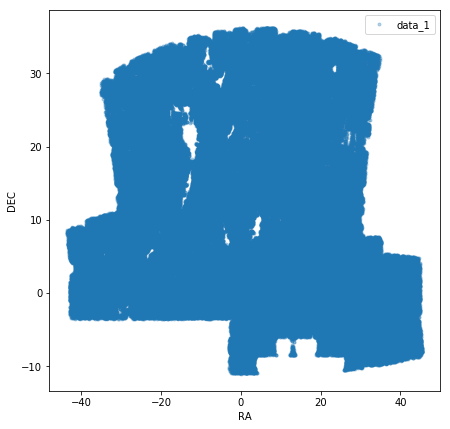

In [236]:
spatialcheck([cmass_sgc])

(40, 180)

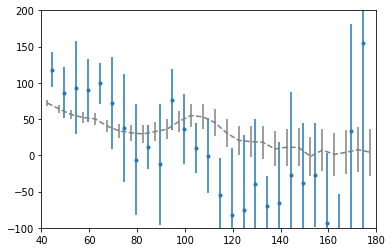

In [339]:
DAT_measurement = np.genfromtxt('../../bandpower/SNR/data_txt/cov/Pellejero-Ibanez/Pellejero-Ibanez_2016_LOWZDR12_CMASSDR12_correlation_function_monopole_z43z75.dat')
r_measurement = DAT_measurement[:,0]
xi_mono_measu = DAT_measurement[:,1]

DAT_measurement = np.genfromtxt('../../bandpower/SNR/data_txt/cov/Pellejero-Ibanez/Pellejero-Ibanez_2016_LOWZDR12_CMASSDR12_correlation_function_quadrupole_z43z75.dat')
r2_measurement = DAT_measurement[:,0]
xi_quad_measu = DAT_measurement[:,1]

ibanez_cov = np.genfromtxt('../../bandpower/SNR/data_txt/cov/Pellejero-Ibanez/Pellejero-Ibanez_2016_CMASSDR12_covariance_matrix.dat') 
ibanez_err0 = np.sqrt(ibanez_cov.diagonal())[:28]
ibanez_err2 = np.sqrt(ibanez_cov.diagonal())[28:]




fig, ax = plt.subplots()

ax.errorbar(r_measurement[7:35], r_measurement[7:35]**2*xi_mono_measu[7:35], yerr = r_measurement[7:35]**2*ibanez_err0,\
            fmt='--', color='grey', label = 'Ibanez et al.')

#ax.errorbar(rr+2, rr**2*monopole, yerr = rr**2*err0, fmt='.')

DAT = np.genfromtxt('data_txt/pair_counting/cmass_sgc_patch2/cfz_multipole_cmass_sgc_patch2.txt')
rr, monopole, err0 = DAT[:,0],  DAT[:,1],  DAT[:,2]
#ax.plot(rr+2, rr**2*monopole)
ax.errorbar(rr+2, rr**2*monopole, yerr = rr**2*err0, fmt='.')
ax.set_ylim(-100, 200)
#ax.plot(sbin_center, sbin_center**2*xi0)
ax.set_xlim(40, 180)

In [124]:
DD = np.genfromtxt('data_txt/pair_counting/d_ngc_0d_ngc_02ptdmu.dat')[1:]
DR = np.genfromtxt('data_txt/pair_counting/d_ngc_0d_ngc_02ptdmu.dat')[1:]
RR = np.genfromtxt('data_txt/pair_counting/d_ngc_0d_ngc_02ptdmu.dat')[1:]

In [125]:
twoptmu_dat = twoptdmu.reshape(250, 100)

In [123]:
rbin = np.linspace(0,250, 251)
mubin = np.linspace(0, 1, 101)

In [213]:
path = '/n/des/lee.5922/data/cmass_cat/'
cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz', ensure_native=True)
#random_ngc = esutil.io.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_North.fits.gz', ensure_native=True)

cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz', ensure_native=True)
#random_sgc = esutil.io.read('/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_South.fits.gz', ensure_native=True)

ind = np.random.choice(np.arange(random_ngc.size), size = random_ngc.size/10)
#ind2 = np.random.choice(np.arange(cmass_ngc.size), size = cmass_ngc.size/10)
random = random_ngc[ind]
#random = adding_dc_column(random)
#cmass = cmass_ngc[ind2]
#cmass = adding_dc_column(cmass)


In [149]:
#rm data_txt/pair_counting/cmass_ngc_test/ddjk0pcadw.dat

In [155]:
#jk_sampling(cmass_ngc, random_ngc[ind], mpi=True, njack=5, suffix='cmass_ngc_test')
_run_paircounting('dd', 'dd', path = 'data_txt/pair_counting/cmass_ngc_test/')
_run_paircounting('dd', 'rr', path = 'data_txt/pair_counting/cmass_ngc_test/')
_run_paircounting('rr', 'rr', path = 'data_txt/pair_counting/cmass_ngc_test/')

JK sampling
X (1573, 2)  centers (5, 2)  tol=1e-05  maxiter=200
34 iterations  cluster sizes: [341 296 326 295 315]
X (618806, 2)  centers (5, 2)  tol=1e-05  maxiter=200
40 iterations  cluster sizes: [131955 135124 120721 115518 115488]
Calculate comoving distance with cosmology 
H0=0.6777, Om0=0.3
Calculate comoving distance with cosmology 
H0=0.6777, Om0=0.3
486851 2540221
file saved to  data_txt/pair_counting/cmass_ngc_test/ddjk1pcadw.dat
Calculate comoving distance with cosmology 
H0=0.6777, Om0=0.3
Calculate comoving distance with cosmology 
H0=0.6777, Om0=0.3
483682 2504999
file saved to  data_txt/pair_counting/cmass_ngc_test/ddjk2pcadw.dat
Calculate comoving distance with cosmology 
H0=0.6777, Om0=0.3
Calculate comoving distance with cosmology 
H0=0.6777, Om0=0.3
498085 2576448
file saved to  data_txt/pair_counting/cmass_ngc_test/ddjk3pcadw.dat
Calculate comoving distance with cosmology 
H0=0.6777, Om0=0.3
Calculate comoving distance with cosmology 
H0=0.6777, Om0=0.3
503288 263

ValueError: cannot create object arrays from iterator

In [ ]:
ind = np.random.choice(np.arange(cmass_ngc.size), size = cmass_ngc.size/10)
from systematics_module.corr import correlation_function_multipoles, _cfz_multipoles
correlation_function_multipoles(data = cmass_ngc[ind], 
                                rand = random, zlabel = 'Z', njack = 5, 
                                weight = False, suffix = 'cmass_test2', nthreads = 20)


calculate correlation function multipoles 0 and 2
# of jackknife sample : 5
# of threads : 20
Ndata : 61880  Nrand : 3215174
corr file will be saved to data_txt/pair_counting/cmass_test2/cfz_multipole.txt
Calculate comoving distance with Planck cosmology 
H0=68.0, Om0=0.305
Cannot find comoving distance column... Adding Comoving distance column
JK sampling
X (497, 2)  centers (5, 2)  tol=1e-05  maxiter=200
14 iterations  cluster sizes: [ 75  87  86 133 116]
X (61880, 2)  centers (5, 2)  tol=1e-05  maxiter=200
14 iterations  cluster sizes: [11416 12631 11829 13631 12373]
data_txt/pair_counting/cmass_test2/dd_jk12.pkl
data_txt/pair_counting/cmass_test2/dr_jk12.pkl
data_txt/pair_counting/cmass_test2/rr_jk12.pkl
data_txt/pair_counting/cmass_test2/dd_jk13.pkl
data_txt/pair_counting/cmass_test2/dr_jk13.pkl
data_txt/pair_counting/cmass_test2/rr_jk13.pkl
data_txt/pair_counting/cmass_test2/dd_jk14.pkl
data_txt/pair_counting/cmass_test2/dr_jk14.pkl


In [211]:
cmass_ngc.size

618806

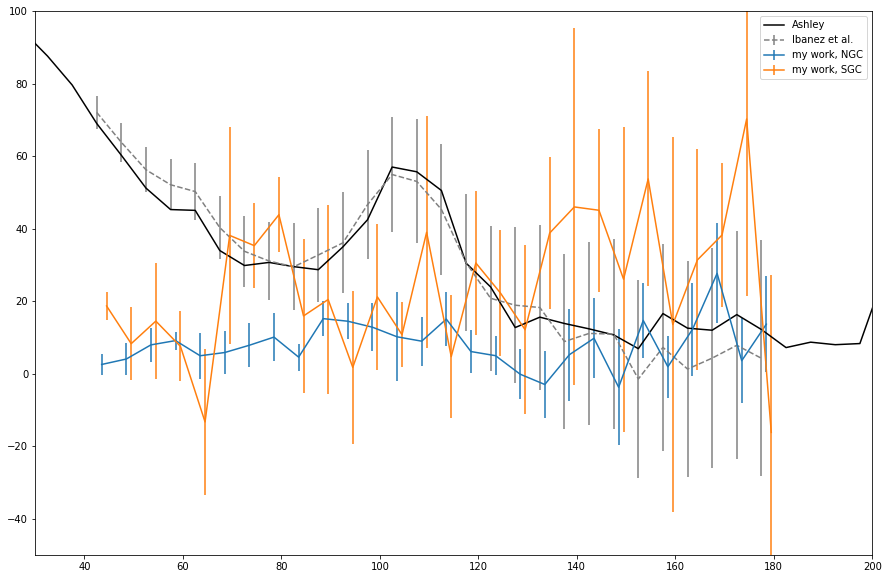

In [19]:
DAT_measurement = np.genfromtxt('../../bandpower/SNR/data_txt/cov/Pellejero-Ibanez/Pellejero-Ibanez_2016_LOWZDR12_CMASSDR12_correlation_function_monopole_z43z75.dat')
r_measurement = DAT_measurement[:,0]
xi_mono_measu = DAT_measurement[:,1]

DAT_measurement = np.genfromtxt('../../bandpower/SNR/data_txt/cov/Pellejero-Ibanez/Pellejero-Ibanez_2016_LOWZDR12_CMASSDR12_correlation_function_quadrupole_z43z75.dat')
r2_measurement = DAT_measurement[:,0]
xi_quad_measu = DAT_measurement[:,1]

ibanez_cov = np.genfromtxt('../../bandpower/SNR/data_txt/cov/Pellejero-Ibanez/Pellejero-Ibanez_2016_CMASSDR12_covariance_matrix.dat') 
ibanez_err0 = np.sqrt(ibanez_cov.diagonal())[:28]
ibanez_err2 = np.sqrt(ibanez_cov.diagonal())[28:]


#DAT = np.genfromtxt('data_txt/pair_counting/cmass_ngc/cfz_multipole_cmass_ngc.txt')
DAT = np.genfromtxt('data_txt/pair_counting/cmass_ngc_jk5/cfz_multipole_cmass_ngc_jk5.txt')
rr, monopole, err0 = DAT[:,0],  DAT[:,1],  DAT[:,2]

fig, ax = plt.subplots(figsize = (15,10))

ax.errorbar(r_measurement[7:35], r_measurement[7:35]**2*xi_mono_measu[7:35], yerr = r_measurement[7:35]**2*ibanez_err0,\
            fmt='--', color='grey', label = 'Ibanez et al.')
ax.errorbar(rr+1, rr**2*monopole, yerr=rr**2*err0, fmt='', label = 'my work, NGC' )



DAT = np.genfromtxt('data_txt/pair_counting/cmass_sgc/cfz_multipole_cmass_sgc.txt')
DAT = np.genfromtxt('data_txt/pair_counting/cmass_sgc_jk5/cfz_multipole_cmass_sgc_jk5.txt')
rr, monopole_sgc, err0 = DAT[:,0],  DAT[:,1],  DAT[:,2]
ax.errorbar(rr+2, rr**2*monopole_sgc, yerr=rr**2*err0, fmt='', label = 'my work, SGC' )

#monopole_full = ( cmass_ngc.size * monopole + cmass_sgc.size * monopole_sgc) *1./(cmass_ngc.size + cmass_sgc.size)
#ax.errorbar(rr+3, rr**2*monopole_full, yerr=rr**2*err0, fmt='', label = 'my work, SGC + NGC')

theory_rr, theory_corr = np.genfromtxt('data_txt/Ashley_cmass/xi0gcmassSdr12v4_mz0.43xz0.7fcos65st0.dat', unpack=True)
theory_rr, theory_corr = np.genfromtxt('data_txt/Ashley_cmass/xi0gcmassNdr12v4_mz0.43xz0.7fcos65st0.dat', unpack=True)
ax.plot(theory_rr, theory_rr**2*theory_corr, 'k-' , label = 'Ashley')
#theory_corr2 = np.genfromtxt('../../bandpower/SNR/data_txt/datav/mcmc_cmass_zcut_xionly_b_monopole.datavector')[1500:1500+28]


#ax.errorbar(sbin_center+1, sbin_center**2*xi_mean, yerr=sbin_center**2*xijkerr, fmt='' )
#ax.errorbar(sbin_center2+2, sbin_center2**2*xi_mean2, yerr=sbin_center2**2*xijkerr2, fmt='' )

ax.set_ylim(-50, 100)
ax.set_xlim(30,200)
ax.legend()

In [336]:

import pickle
import scipy
from systematics_module.corr import cf_smu


def xi_from_dat(root = 'data_txt/pair_counting/', suffix = ['', ''] ):


    smin = 40
    smax = 180
    snbin = 29

    sbin, step = np.linspace(smin, smax, snbin, retstep=True)

    sbin_center = sbin[:-1] + step/2.
    mubin, mus = np.linspace(0.0, 1.0, 101, retstep = True)
    mucenter = mubin[:-1]+mus/2.

    xilist = []

    for s in suffix:
        _root = root + s+'/'
        for i in range(100):
            dd_picklename = _root+'djk{}djk{}2ptdmu.dat'.format(i,i)
            dr_picklename = _root+'djk{}rjk{}2ptdmu.dat'.format(i,i)
            rr_picklename = _root+'rjk{}rjk{}2ptdmu.dat'.format(i,i)
            if os.path.exists(dd_picklename):
                print dd_picklename
                
                dd = np.loadtxt(dd_picklename)[1:] *1./np.loadtxt(dd_picklename)[0] 
                dr = np.loadtxt(dr_picklename)[1:] *1./np.loadtxt(dr_picklename)[0]
                rr = np.loadtxt(rr_picklename)[1:] *1./np.loadtxt(rr_picklename)[0]

                xi_smu = _cf_smu( dd, dr, rr, sbin, mubin)                
                
                legendre0 = np.array([scipy.special.eval_legendre(0,m) for m in mucenter]).ravel() 
                #legendre2 = np.array([scipy.special.eval_legendre(2,m) for m in mucenter]).ravel() 

                xi_monopole = np.sum(xi_smu * legendre0.T, axis = 1)/mucenter.size
                #xi_quadrupole = 5*np.sum(xi_smu * legendre2.T, axis = 1)/mucenter.size

                xilist.append(xi_monopole)

            else : break

                
    
    njack = len(xilist)-1
    
    xi_data = np.column_stack((xilist))
    np.savetxt(root+'/xi_jk.txt', xi_data )
    xi_mean = np.mean(xilist, axis = 0)
    norm = 1. * (njack-1)/njack

    xi_cov = 0
    for k in range(njack):
        xi_cov +=  (xilist[k] - xi_mean)**2
    xijkerr = np.sqrt(norm * xi_cov)
    
    DAT = np.column_stack((sbin_center, xi_mean, xijkerr))
    if len(suffix) == 1 : txtname = _root+'cfz_multipole'
    elif len(suffix) > 1 : txtname = root+'cfz_multipole_combine'
    for s in suffix : txtname += '_'+s

    np.savetxt(txtname+'.txt', DAT)
    print 'data save to ', txtname+'.txt'

data_txt/pair_counting/cmass_sgc_patch2/djk0djk02ptdmu.dat


ZeroDivisionError: float division by zero

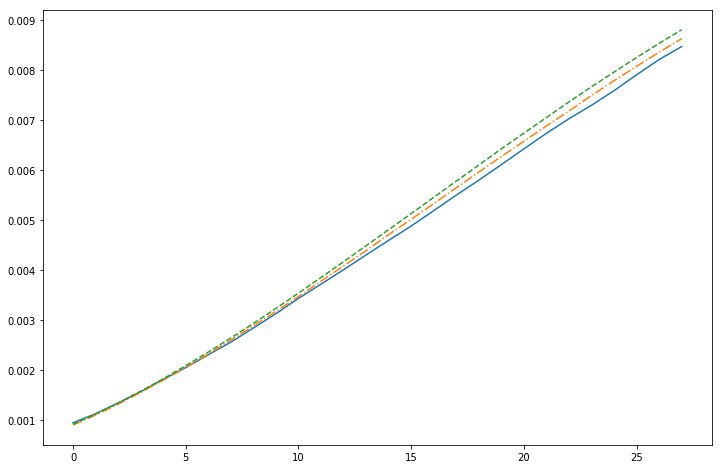

In [337]:
xi_from_dat(root = 'data_txt/pair_counting/', suffix = ['cmass_sgc_patch2'] )

In [304]:
dd = np.genfromtxt('data_txt/pair_counting/cmass_ngc_jk5/ddjk0ddjk02ptdmu.dat')
norm_dd = (dd[1:] * 1./dd[0]).reshape(250, 100)
norm_dd_s = np.sum(norm_dd, axis = 1)

dr = np.genfromtxt('data_txt/pair_counting/cmass_ngc_jk5/ddjk0rrjk02ptdmu.dat')
norm_dr = (dr[1:] * 1./dr[0]).reshape(250, 100)
norm_dr_s = np.sum(norm_dr, axis = 1)

rr = np.genfromtxt('data_txt/pair_counting/cmass_ngc_jk5/rrjk0rrjk02ptdmu.dat')
norm_rr = (rr[1:] * 1./rr[0]).reshape(250, 100)
norm_rr_s = np.sum(norm_rr, axis = 1)

In [16]:


import pickle
import scipy
from systematics_module.corr import cf_smu, rp_pi_counts_to_smu
root = 'data_txt/pair_counting/cmass_test2/'


def xi_from_pickle(root = 'data_txt/pair_counting/', suffix = ['', ''] ):


    smin = 40
    smax = 180
    snbin = 29

    sbin, step = np.linspace(smin, smax, snbin, retstep=True)

    sbin_center = sbin[:-1] + step/2.
    mubin, mus = np.linspace(0.0, 1.0, 101, retstep = True)
    mucenter = mubin[:-1]+mus/2.

    xilist = []

    for s in suffix:
        _root = root + s+'/'
        for i in range(100):
            dd_picklename = _root+'dd_jk{}.pkl'.format(i)
            dr_picklename = _root+'dr_jk{}.pkl'.format(i)
            rr_picklename = _root+'rr_jk{}.pkl'.format(i)
            if os.path.exists(dd_picklename):
                print dd_picklename
                dd = pickle.load(open(dd_picklename))
                dr = pickle.load(open(dr_picklename))
                rr = pickle.load(open(rr_picklename))

                xi_smu = cf_smu( dd, dr, rr, sbin, mubin, None, None)

                legendre0 = np.array([scipy.special.eval_legendre(0,m) for m in mucenter]).ravel() 
                #legendre2 = np.array([scipy.special.eval_legendre(2,m) for m in mucenter]).ravel() 

                xi_monopole = np.sum(xi_smu * legendre0.T, axis = 1)/mucenter.size
                #xi_quadrupole = 5*np.sum(xi_smu * legendre2.T, axis = 1)/mucenter.size

                xilist.append(xi_monopole)

            else : break

    njack = len(xilist)-1
    xi_mean = np.mean(xilist, axis = 0)
    norm = 1. * (njack-1)/njack

    xi_cov = 0
    for k in range(njack):
        xi_cov +=  (xilist[k] - xi_mean)**2
    xijkerr = np.sqrt(norm * xi_cov)
    
    DAT = np.column_stack((sbin_center, xi_mean, xijkerr))
    if len(suffix) == 1 : txtname = _root+'cfz_multipole'
    elif len(suffix) > 1 : txtname = root+'cfz_multipole_combine'
    for s in suffix : txtname += '_'+s

    np.savetxt(txtname+'.txt', DAT)
    print 'data save to ', txtname+'.txt'

In [17]:
xi_from_pickle(root = 'data_txt/pair_counting/', suffix = ['cmass_ngc'] )

data_txt/pair_counting/cmass_ngc/dd_jk0.pkl


systematics_module/corr.py:86: RuntimeWarning: invalid value encountered in divide
  


data_txt/pair_counting/cmass_ngc/dd_jk1.pkl
data_txt/pair_counting/cmass_ngc/dd_jk2.pkl
data_txt/pair_counting/cmass_ngc/dd_jk3.pkl
data_txt/pair_counting/cmass_ngc/dd_jk4.pkl
data_txt/pair_counting/cmass_ngc/dd_jk5.pkl
data_txt/pair_counting/cmass_ngc/dd_jk6.pkl
data_txt/pair_counting/cmass_ngc/dd_jk7.pkl
data_txt/pair_counting/cmass_ngc/dd_jk8.pkl
data_txt/pair_counting/cmass_ngc/dd_jk9.pkl
data_txt/pair_counting/cmass_ngc/dd_jk10.pkl
data_txt/pair_counting/cmass_ngc/dd_jk11.pkl
data_txt/pair_counting/cmass_ngc/dd_jk12.pkl
data_txt/pair_counting/cmass_ngc/dd_jk13.pkl
data_txt/pair_counting/cmass_ngc/dd_jk14.pkl
data_txt/pair_counting/cmass_ngc/dd_jk15.pkl
data_txt/pair_counting/cmass_ngc/dd_jk16.pkl
data_txt/pair_counting/cmass_ngc/dd_jk17.pkl
data_txt/pair_counting/cmass_ngc/dd_jk18.pkl
data_txt/pair_counting/cmass_ngc/dd_jk19.pkl
data_txt/pair_counting/cmass_ngc/dd_jk20.pkl
data save to  data_txt/pair_counting/cmass_ngc/cfz_multipole_cmass_ngc.txt


In [272]:
cmass_ngc.size, random_ngc.size/10

(618806, 3215174)

In [ ]:
constructing_input_file(cmass_sub, suffix = 'd_ngc_sub')

In [92]:
run_Ashley_paircounting('d_ngc_sub', 'd_ngc_sub', isrand=False)

/n/des/lee.5922/programs/LSSanalysis/pp2pt_Dmufb d_ngc_sub_0 d_ngc_sub_0


In [86]:
#ddpair
prefix1 = 'd_ngc'
prefix2 = 'd_ngc'
run_Ashley_paircounting(prefix1, prefix2, isrand=False)
#run_Ashley_paircounting(prefix1, prefix2, isrand=True)

/n/des/lee.5922/programs/LSSanalysis/pp2pt_Dmufb d_ngc_0 d_ngc_0


In [370]:
    from scipy.interpolate import interp1d
    import scipy

16 16


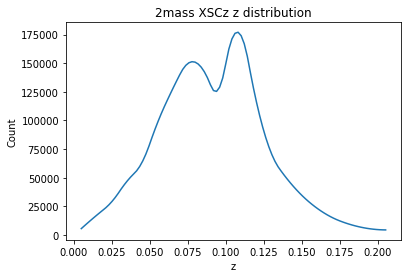

In [440]:
def twomass_zdist():
    
    zdist = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/zdistribution_2masx_v2.txt')
    zbin = zdist[:,0]
    #zbin_sta = zbin[:-1]
    #zbin_mid = [zbin[i] + (zbin[i+1] - zbin[i])/2. for i in range(zbin.size-1)]
    zbin_mid = (zbin + 0.005)
    zbin_end = zdist[:,1]
    Ngal = zdist[:,2]
    
    print zbin_mid.size, Ngal.size
    fig, ax = plt.subplots()
    #ax.plot(zbin_sta, Ngal, '.')
    #ax.plot(zbin_mid, Ngal,'.')
    #ax.plot(zbin_end, Ngal,'.')
    

    #zbin_mid = np.append(zbin_mid,0.23)
    #Ngal = np.append(Ngal,0.0)
    
    #zbin_mid = np.insert(zbin_mid, 0, 0)
    #Ngal = np.insert(Ngal, 0, 0)
    
    zbin_even, step = np.linspace(zbin_mid[0], zbin_mid[-1], 100, retstep=True)
    Ngal_interp = interp1d(zbin_mid, Ngal, kind='quadratic')
    Ngal_interp = Ngal_interp(zbin_even)
    #print Ngal_interp
    ax.plot(zbin_even, Ngal_interp )
    
    #print zbin_even
    
    zbin_interp_start = zbin_even - step/2.
    zbin_interp_end = zbin_even + step/2.
    ax.set_title('2mass XSCz z distribution')
    ax.set_xlabel('z')
    ax.set_ylabel('Count')
    
    #DAT = np.column_stack((zbin_interp_start, zbin_even, zbin_interp_end, Ngal_interp))
    #np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/zdistribution_2masx.nz',DAT, 
    #          header = 'zmin, zavg, zmax, Ngal')
twomass_zdist()

In [328]:
def catalog_masking(cat, nside_out = 128, area=None):
    
    cat = reddening_mask(cat = cat, nside_out = nside_out)
    if area is 'NGC' :
        cat = boss_mask(cat=cat, nside_out = nside_out, area=area)
    elif area is 'SGC' :
        cat = boss_mask(cat=cat, nside_out = nside_out, area=area)    
    elif area is 'SPT':
        cat = Cuts.keepGoodRegion(cat)
        cat = y1gold_mask(cat = cat, nside_out = nside_out)
    else : print 'area keyword input : either one of NGC SGC SPT'
    return cat

In [249]:
def making_healpix_density_map(cat = None, nside = 128, nest = False, ext_weight = None):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )   
    
    seen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'int'), ('KAPPA', 'float')])
    Ntot = cat.size
    Npix = np.sum(seen)
    Atot = pixarea * Npix
    ntot = Ntot *1./Atot
    ngal = N_gal *1./pixarea
    

    print 'Ntot', Ntot
    #print 'Ngal', N_gal
    print 'mean Ngal', np.mean(N_gal[seen])
    print 'Npix', Npix
    #print 'Map.size', Map.shape
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal 
    Map['WEIGHT'] = seen #  ( ngal*1./ntot - 1.)*1./Npix
    Map['KAPPA'] =  (N_gal*1./Ntot * Npix -1.)
    #Map['KAPPA'][~seen] = 0.0
    #Map['WEIGHT'][unseen] = 0
    #Map['WEIGHT_RAND'] = unseen
    return Map

In [250]:
def _making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    seen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'int'), ('KAPPA', 'float') , ('WEIGHT_RAND', 'int') ])
    Ntot = cat.size
    Npix = len(set(cat_ind))
    print np.sum(seen), Npix
    Atot = pixarea * Npix
    ntot = Ntot *1./Atot
    ngal = N_gal *1./pixarea
    

    print 'Ngaltot', Ntot
    print 'Ngal mean', np.mean(N_gal)
    #print 'Ngal', N_gal
    print 'Npix', Npix
    print 'Map.size', Map.shape
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal 
    #Map['WEIGHT'] = (N_gal*1./Ntot * Npix -1.)#  ( ngal*1./ntot - 1.)*1./Npix
    #Map['WEIGHT'][N_gal == 0] = 0
    Map['KAPPA'] =  (N_gal*1./Ntot * Npix -1.)
    #Map['KAPPA'][N_gal==0] = 0.0
    Map['WEIGHT'] = seen
    return Map

In [326]:
def y1gold_mask(cat=None, nside_out = 128):
    
    path = '/n/des/lee.5922/data/systematic_maps/'
    LSSGoldmask_hpind = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')['PIXEL']
    hpind_frac = np.zeros(hp.nside2npix(4096), dtype = 'float')
    hpind_frac[LSSGoldmask_hpind] = 1.0
    hpind_frac_ud = hp.ud_grade(hpind_frac, pess=True, nside_out = nside_out)
    
    hpind_up = np.arange(hp.nside2npix(nside_out))
    
    cat = cat[cat['DEC']<-3.0]
    cat_hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(cat_hpind, hpind_up[[ hpind_frac_ud > 0.8]])
    return cat[goodind]  

In [252]:
def boss_mask(cat=None, area='SGC', nside_out = 128):
    

    if area is 'SGC' : 
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')
        
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)

    elif area is 'NGC':
        boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')
        #boss_hpind = hp.ud_grade(boss_hpind, pess=True, nside_out = nside)
    else : 
        print 'area keyword input : SGC or NGC'
        return 0
     
    boss_hpfrac = np.zeros(hp.nside2npix(1024), dtype = 'float')
    boss_hpfrac[boss_hpind] = 1.0
    boss_hpfrac_ud = hp.ud_grade(boss_hpfrac, pess=True, nside_out = nside_out)
    #boss_hpfrac_ud[ boss_hpfrac_ud < 0.8] = 0
    
    boss_hpind_up = np.arange(hp.nside2npix(nside_out))
    #print boss_hpfrac
    
    
    #boss_hpfrac_ud2 = boss_hpfrac_ud.copy()
    #boss_hpfrac_ud2[ boss_hpfrac_ud > 0.8] = 0
    #hp.mollview( boss_hpfrac_ud2, max = 1, nest = False)
    
    #if cat is None : 
    #    boss_hpmask = np.zeros(hp.nside2npix(4096), dtype = 'bool')
    #    boss_hpmask[boss_hpind] = 1
    #    return boss_hpmask
    
    #elif cat is not None : 
        
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside_out, nest= False) 
    goodind = np.in1d(hpind, boss_hpind_up[[ boss_hpfrac_ud > 0.8]])
    return cat[goodind]

In [253]:
def reddening_mask(cat = None, nside_out = 128):
    
    reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits', ensure_native=True)
    reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
    reddening_ring_ud = hp.ud_grade(reddening_ring, pess=True, nside_out = nside_out)
    reddening = rotate_hp_map(reddening_ring_ud, coord = ['C', 'G'])

    reddening_mask = reddening < 0.05 /0.367
    
    hpind_up = np.arange(hp.nside2npix(nside_out))
    
    cathpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=  nside_out, nest= False)
    mask = np.in1d(cathpind, hpind_up[reddening_mask])
    
    return cat[mask]

In [254]:
def _making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    unseen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'float') ,  ('WEIGHT_RAND', 'bool') ])
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal   
    #Map['WEIGHT'] = N_gal*1./pixarea 
    Map['WEIGHT'] = unseen
    return Map